# Tree Crown Detection

The delineation of individual trees in remote sensing images is an key task in forest analysis. As part of Sebastian Hickman's AI4ER MRes project, titled 'Detecting changes in tall tree height with machine learning, LiDAR, and RGB imagery', the authors propose the `detectreeRGB` model, an implementation of Mask R-CNN from [Detectron2](https://github.com/facebookresearch/detectron2) to perform tree crown delineation from RGB imagery.

<img src="https://github.com/shmh40/detectreeRGB/blob/main/imgs/plot_13_285520_583300.jpg?raw=true" width="400">

**Figure 1** Example image of the predictions made by Mask R-CNN. Source: [Hickman et al. (2021)](https://github.com/shmh40/detectreeRGB).

<div class="alert alert-block alert-info">
     <p>   
        In this notebook, we'll walk through how scivision can assist in discovering a pretrained detectreeRGB model provided by Hickman et al (2021), and then use it to delineate crowns from a sample drone RGB image dataset.
    </p> 
    <p>    
    Further details of the detectreeRGB can be found in 
        <a href="https://github.com/shmh40/detectreeRGB/"> the original model repository</a>.
    </p>     
</div>

## Load libraries

In [1]:
from scivision.catalog import default_catalog
from scivision.io import load_dataset, load_pretrained_model
from intake_zenodo_fetcher import download_zenodo_files_for_entry
import matplotlib.pyplot as plt

## Catalog
We'll use the detectreeRGB model which is registered in the `scivision` model catalog as `detectreeRGB-forest`. Then we'll look with compatible_datasources potential data entries registered in the scivision data catalog with tasks and format compatible with the model.

In [2]:
model_name = 'detectreeRGB-forest'

In [3]:
compatible_datasources = default_catalog.compatible_datasources(model_name).to_dataframe()

This returns a `pandas.dataframe` with the number of potential datasets to pair the model with.

In [4]:
compatible_datasources

,name,description,tasks,domains,url,format,labels_provided,institution,tags
0,data-000,None,"(TaskEnum.object_detection, TaskEnum.segmentat...","(optical-microscopy,)",https://github.com/stardist/stardist/releases/...,image,True,"(epfl,)","(help-needed, 3D, cell, cell-counting, biology..."
1,data-001,None,"(TaskEnum.segmentation, TaskEnum.thresholding,...","(multispectral, hyperspectral)",https://gitlab.au.dk/AUENG-Vision/OPPD/-/archi...,image,True,"(Aarhus University,)","(help-needed, 2D, plant-phenotyping, agricultu..."
3,data-003,Koala,"(TaskEnum.object_detection, TaskEnum.classific...","(computer-vision,)",https://github.com/alan-turing-institute/scivi...,image,True,"(Wikipedia by Erik Veland,)","(demo,)"
5,data-005,Sample dataset of satellite imagery required t...,"(TaskEnum.classificiation, TaskEnum.segmentation)","(computer-vision, earth-observation, ecology)",https://github.com/MartinSJRogers/VEdge_Detect...,image,False,"(Cambridge University,)","(2D, satellite, remote-sensing, ecology, envir..."
6,data-006,Sample dataset of drone RGB imagery required t...,"(TaskEnum.object_detection, TaskEnum.segmentat...","(computer-vision, earth-observation, ecology)",https://github.com/acocac/detectreeRGB-treecro...,image,False,"(Cambridge University,)","(2D, drone, satellite, aerial, remote-sensing,..."


## Model
The following lines will look for the model URL (in this case the GitHub repository) from the scivision model catalog. After, the `load_pretrained_model` function will recognise the URL and install dependencies if they are not yet in the current virtual environment.

In [5]:
models = default_catalog.models.to_dataframe()
targetmodel = models[models.name == model_name].url.item()
model = load_pretrained_model(targetmodel, allow_install=True)

  Cloning https://github.com/acocac/detectreeRGB-treecrown-scivision (to revision main) to /private/var/folders/l8/99_59fvn4bl2szm125grkgqw0000gr/T/pip-install-xpdggdix/detectreergb-treecrown-scivision_b63bb2d6c0d046b7abd103688f0cb13b


  Running command git clone --filter=blob:none --quiet https://github.com/acocac/detectreeRGB-treecrown-scivision /private/var/folders/l8/99_59fvn4bl2szm125grkgqw0000gr/T/pip-install-xpdggdix/detectreergb-treecrown-scivision_b63bb2d6c0d046b7abd103688f0cb13b


  Resolved https://github.com/acocac/detectreeRGB-treecrown-scivision to commit 541752774e197f528a902a6442cf0d69724ecd8b
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.6) to /private/var/folders/l8/99_59fvn4bl2szm125grkgqw0000gr/T/pip-install-xpdggdix/detectron2_0f5372af511640c8bc43cbe33d152dc3


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /private/var/folders/l8/99_59fvn4bl2szm125grkgqw0000gr/T/pip-install-xpdggdix/detectron2_0f5372af511640c8bc43cbe33d152dc3
  Running command git checkout -q d1e04565d3bec8719335b88be9e9b961bf3ec464


  Resolved https://github.com/facebookresearch/detectron2.git to commit d1e04565d3bec8719335b88be9e9b961bf3ec464
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): fin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.7/961.7 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.7/123.7 kB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.9/224.9 kB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 11.9 MB/s eta 0:00:00
  Created wheel for detectreeRGB_treecrown_scivision: filename=detectreeRGB_treecrown_scivision-0.0.1-py3-none-any.whl size=4130 sha256=1b83a980e0a057605d5c4701a88c80bccb8e32511c0d0bf4c953f145dbdb5ad6
  Stored in directory: /private/var/folders/l8/99_59fvn4bl2szm125grkgqw0000gr/T/pip-ephem-wheel-cache-keqhdq25/wheels/f9/7e/b5/a4f24553eca0267f414ba1de7aadc

  Attempting uninstall: toml
    Found existing installation: toml 0.10.2
    Uninstalling toml-0.10.2:
      Successfully uninstalled toml-0.10.2
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.8.10
    Uninstalling tabulate-0.8.10:
      Successfully uninstalled tabulate-0.8.10
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: setuptools
    Found existing installation: setuptools 63.2.0
    Uninstalling setuptools-63.2.0:
      Successfully uninstalled setuptools-63.2.0
  Attempting uninstall: rsa
    Found existing installation: rsa 4.8
    Uninstalling rsa-4.8:
      Successfully uninstalled rsa-4.8
  Attempting uninstall

  Attempting uninstall: fvcore
    Found existing installation: fvcore 0.1.5.post20220512
    Uninstalling fvcore-0.1.5.post20220512:
      Successfully uninstalled fvcore-0.1.5.post20220512
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.4.6
    Uninstalling google-auth-oauthlib-0.4.6:
      Successfully uninstalled google-auth-oauthlib-0.4.6
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: detectron2
    Found existing installation: detectron2 0.6
    Uninstalling detectron2-0.6:
      Successfully uninstalled detectron2-0.6


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cffconvert 2.0.0 requires jsonschema<4,>=3.0, but you have jsonschema 4.7.2 which is incompatible.


In [6]:
model

scivision.PretrainedModel( 
  module='detectreeRGB_treecrown_scivision', 
  model='DetectreeRGB', 
  source='https://github.com/acocac/detectreeRGB-treecrown-scivision' 
  pipe='DataPipe(input=<Parameter "X: numpy.ndarray">, output=<Parameter "image: numpy.ndarray">)' 
)

## Data

We'll load one of the suggested datasets in compatible_datasources. In this case, we will use the dataset registered with the name field equals to data-006. This refers to a drone image dataset kindly shared by Hickman et al. in a [zenodo repository](https://zenodo.org/record/5090039#.Ys_rxC8w1pQ) to demonstrate the `detectreeRGB` model.

In [7]:
target_datasource = compatible_datasources.loc[compatible_datasources['name'] == 'data-006']
target_datasource

,name,description,tasks,domains,url,format,labels_provided,institution,tags
6,data-006,Sample dataset of drone RGB imagery required t...,"(TaskEnum.object_detection, TaskEnum.segmentat...","(computer-vision, earth-observation, ecology)",https://github.com/acocac/detectreeRGB-treecro...,image,False,"(Cambridge University,)","(2D, drone, satellite, aerial, remote-sensing,..."


In [8]:
cat = load_dataset(target_datasource.url.item()) 
download_zenodo_files_for_entry(cat.sepilok_rgb, force_download=False)
dataset = cat.sepilok_rgb().to_dask()

In dataset, the sample image, which actually has an RGB bands plus additional band, is loaded into single `xarray.Dataset` object with a defined dimension, in this case 1400 px x 1400 px. 

In [9]:
dataset

<xarray.DataArray (band: 4, y: 1400, x: 1400)>
array([[[36166.285 , 34107.22  , ..., 20260.998 , 11166.631 ],
        [32514.84  , 28165.994 , ..., 24376.36  , 21131.947 ],
        ...,
        [15429.493 , 16034.794 , ..., 19893.691 , 19647.646 ],
        [12534.722 , 14003.215 , ..., 21438.908 , 22092.525 ]],

       [[38177.168 , 36530.74  , ..., 19060.268 , 11169.006 ],
        [34625.227 , 30270.379 , ..., 21760.09  , 20796.621 ],
        ...,
        [17757.678 , 16818.102 , ..., 22538.023 , 23093.508 ],
        [13403.302 , 13354.489 , ..., 24638.21  , 25545.938 ]],

       [[13849.501 , 14158.603 , ...,  9385.764 ,  7401.662 ],
        [13252.31  , 13373.801 , ..., 12217.845 , 10666.252 ],
        ...,
        [13471.741 , 11533.697 , ...,  7536.6924,  8397.009 ],
        [13724.59  , 11057.722 , ...,  9778.8125, 11174.72  ]],

       [[65535.    , 65535.    , ..., 65535.    , 65535.    ],
        [65535.    , 65535.    , ..., 65535.    , 65535.    ],
        ...,
        [65535.    , 65535.    , ..., 65535.    , 65535.    ],
        [65535.    , 65535.    , ..., 65535.    , 65535.    ]]], dtype=float32)
Coordinates:
  * band     (band) int64 1 2 3 4
  * y        (y) float64 6.467e+05 6.467e+05 6.467e+05 ... 6.466e+05 6.466e+05
  * x        (x) float64 6.025e+05 6.025e+05 6.025e+05 ... 6.026e+05 6.026e+05
Attributes:
    transform:      (0.1, 0.0, 602480.0, 0.0, -0.1, 646720.0)
    crs:            +init=epsg:32650
    res:            (0.1, 0.1)
    is_tiled:       0
    nodatavals:     (-3.3999999521443642e+38, -3.3999999521443642e+38, -3.399...
    scales:         (1.0, 1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0, 0.0)
    AREA_OR_POINT:  Area

## Prediction and visualisation
Once we load model and data, we will use the predict function previously defined within the scivision configuration file of the model. In this example, the predict function goes over the RGB bands of the image and we enable the `plot` argument to plot the predictions over the drone RGB image. If we set `plot=False`, it will only return the instance values which can be then plotted as it is indicated in the example of detectreeRGB in the Environmental Data Science book (see [here](https://the-environmental-ds-book.netlify.app/gallery/modelling/forest-modelling-treecrown_detectreergb/forest-modelling-treecrown_detectreergb#showing-the-predictions-from-detectreergb)).

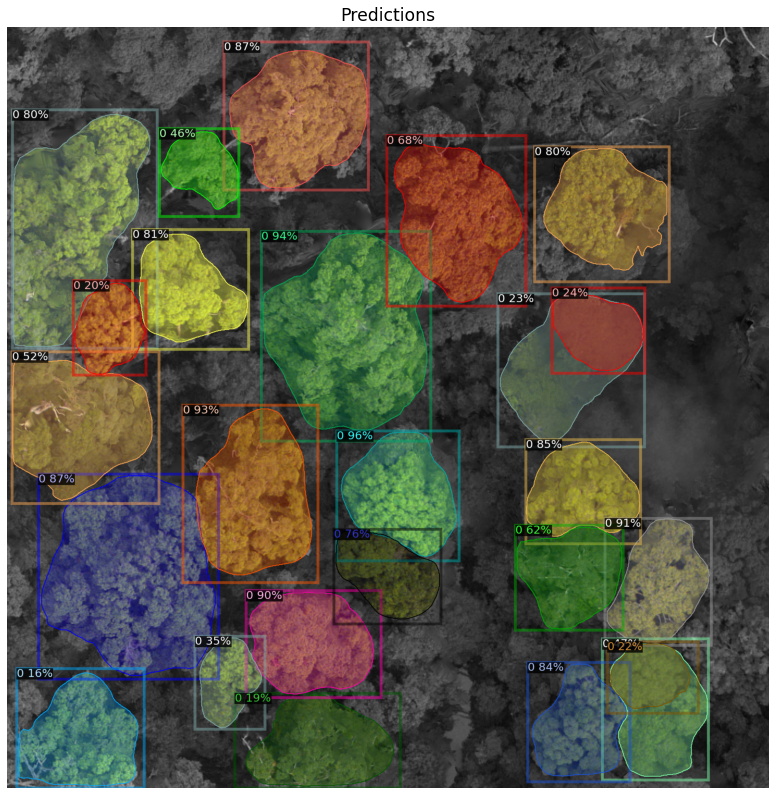

In [10]:
y = model.predict(dataset.sel(band=slice(1,3)), plot=True)